# Hall frequency

In [36]:
import os
import pandas as pd
import matplotlib.pyplot as plt

HALL_GALLONS_PER_TICK = 0.0009
HALL_TICKLIST_FILE = f'/Users/thomas/Desktop/abstime/{[file for file in sorted(os.listdir('/Users/thomas/Desktop/abstime/')) if 'hall_ticklist' in file][-1]}'
HALL_FILTERED_FILE = f'/Users/thomas/Desktop/abstime/{[file for file in sorted(os.listdir('/Users/thomas/Desktop/abstime/')) if 'hall_frequency' in file][-1]}'

In [37]:
def plot_freq(df, given_title):
    fig, ax = plt.subplots(1,1)
    ax2 = ax.twinx()
    ax.plot(df.timestamp, df.frequency)
    ax2.plot(df.timestamp, df.gpm)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency [Hz]')
    ax2.set_ylabel(f'GPM ({HALL_GALLONS_PER_TICK} gallons per tick)')
    ax.set_title(given_title)
    plt.tight_layout()
    plt.show()

### Ticklists

,timestamp,frequency,tick_delta_us,pico_pi_time_difference_ns
0,1.729399e+18,11.534021,0,2.519917e+13
1,1.729399e+18,15.203380,86700,2.519917e+13
2,1.729399e+18,20.234710,152475,2.519917e+13
3,1.729399e+18,22.974698,201895,2.519917e+13
4,1.729399e+18,24.854610,245421,2.519917e+13
5,1.729399e+18,29.905222,285655,2.519917e+13
6,1.729399e+18,31.302839,319094,2.519917e+13
7,1.729399e+18,31.921370,351040,2.519917e+13
8,1.729399e+18,36.779591,382367,2.519917e+13
9,1.729399e+18,37.523294,409556,2.519917e+13


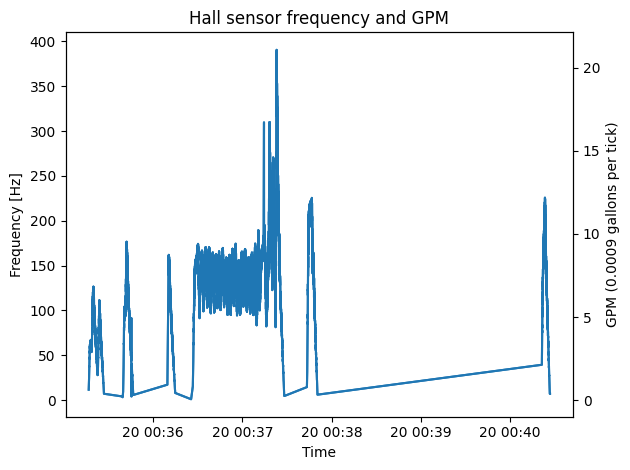

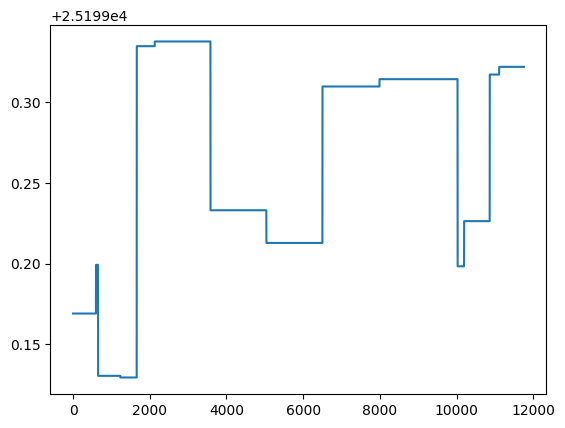

25199.33746304
25199.129434112


In [38]:
if os.path.exists(HALL_TICKLIST_FILE):
    
    df_ticklist = pd.read_csv(HALL_TICKLIST_FILE)
    # df_ticklist = df_ticklist[2746:]
    display(df_ticklist[:10])

    # import time
    # pi_timestamps = sorted(list(set([time.time_ns() + x*1e3 for x in df_ticklist['tick_delta_us']])))
    # frequency = [1/(t2-t1)*1e9 for t1,t2 in zip(pi_timestamps[:-1], pi_timestamps[1:])]
    # frequency = frequency + [frequency[-1]]
    # plt.plot(pi_timestamps, frequency)

    # display(df_ticklist[2746:])


    
    # df_ticklist = df_ticklist[df_ticklist.frequency<500]
    
    df_ticklist['timestamp'] = pd.to_datetime(list(df_ticklist['timestamp']), unit='ns', utc=True).tz_convert('America/New_York')
    df_ticklist['gpm'] = [x * HALL_GALLONS_PER_TICK * 60 for x in list(df_ticklist['frequency'])] 
    plot_freq(df_ticklist, "Hall sensor frequency and GPM")

    plt.plot(df_ticklist['pico_pi_time_difference_ns']/1e9)
    plt.show()
    print(max(df_ticklist['pico_pi_time_difference_ns'])/1e9)
    print(min(df_ticklist['pico_pi_time_difference_ns'])/1e9)

In [39]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt

def filter_and_record(timestamps:list[float|int], last_recorded_frequency, f_s_factor:int=4, f_c:float=1.25, threshold:float=0):

    if len(timestamps)<=1:
        return [], []

    # Compute the time differences and frequency
    timediff = [(t2-t1) for t1,t2 in zip(timestamps[:-1], timestamps[1:])]
    frequency = [1/(t2-t1)*1e9 for t1,t2 in zip(timestamps[:-1], timestamps[1:])]
    timediff = timediff + [timediff[-1]]
    frequency = frequency + [frequency[-1]]
    
    # Remove the first tick if the frequency dropped by more than 0.5 Hz just after it (common issue after publishing)
    if frequency[0]-frequency[1] > 0.5:
        frequency.pop(0)
        timediff.pop(0)
        timestamps.pop(0)

    # Remove outliers (frequency above allowed maximum)
    max_frequency = 500 # Hz
    timestamps = [timestamps[i] for i in range(len(frequency)) if frequency[i]<max_frequency]
    timediff = [timediff[i] for i in range(len(frequency)) if frequency[i]<max_frequency]
    frequency = [x for x in frequency if x<max_frequency]

    # Only filter timestamp lists that are large enough
    if len(timestamps) > 20:

        # Add the last recorded frequency before the filtering (avoids overfitting the first point)
        if last_recorded_frequency > 0:
            timestamps = [timestamps[0]-0.01*1e9] + timestamps
            timediff = [1000/last_recorded_frequency] + timediff

        # Re-sample time with equal spacing at sampling frequency f_s, using linear interpolation
        f_s = f_s_factor*max(frequency)
        sampled_timestamps = np.linspace(min(timestamps), max(timestamps), int((max(timestamps)-min(timestamps))/1e9 * f_s))
        interpolation_func = interp1d(timestamps, timediff, kind='linear')
        interpolated_timediff = interpolation_func(sampled_timestamps)

        # Filter the sampled signal using a butterworth low-pass filter
        b, a = butter(N=5, Wn=f_c, fs=f_s, btype='low', analog=False)
        filtered_timediff = filtfilt(b, a, interpolated_timediff)

        # Remove the first points from the last recorded frequency added 12 lines before this one
        if last_recorded_frequency > 0:
            filtered_timediff = [filtered_timediff[i] for i in range(len(filtered_timediff)) if sampled_timestamps[i]>=timestamps[1]]
            sampled_timestamps = [x for x in sampled_timestamps if x>=timestamps[1]]
            timestamps = timestamps[1:]

        # Convert the filtered time differences (ns) to frequency (Hz)
        filtered_frequency = [1/x*1e9 for x in filtered_timediff]

    else:
        sampled_timestamps = timestamps
        filtered_frequency = frequency

    # Record points where the difference between consecutive frequencies exceeds the threshold, starting from the last recorded frequency
    recorded_frequencies = [last_recorded_frequency]
    recorded_timestamps = [sampled_timestamps[0]]
    for i in range(1, len(filtered_frequency)):
        last_recorded_time = recorded_timestamps[-1]
        if abs(filtered_frequency[i] - recorded_frequencies[-1]) > threshold:

            # If more than 2 seconds went by since the previous point
            if sampled_timestamps[i] - recorded_timestamps[-1] >= 2*1e9:

                # Add points 0.25 and 0.75 seconds after the previous point
                for sec in range(25,100,50):
                    sec = sec/100*1e9
                    following_sec = [x for x in sampled_timestamps if x<last_recorded_time+sec]
                    recorded_frequencies.append(filtered_frequency[:len(following_sec)][-1])
                    recorded_timestamps.append(following_sec[-1])

                # Add points 0.25 and 0.75 seconds before the current point
                for sec in range(25,100,50):
                    sec = (1-sec/100)*1e9
                    previous_sec = [x for x in sampled_timestamps if x<sampled_timestamps[i]-sec]
                    recorded_frequencies.append(filtered_frequency[:len(previous_sec)][-1])
                    recorded_timestamps.append(previous_sec[-1])

            recorded_frequencies.append(filtered_frequency[i])
            recorded_timestamps.append(sampled_timestamps[i])

    # Remove the last recorded frequency (global)
    recorded_frequencies = recorded_frequencies[1:]
    recorded_timestamps = recorded_timestamps[1:]

    if recorded_frequencies:
        print(f"Timestamps were filtered and frequency recorded, reducing the data size {round(len(timestamps)/len(recorded_timestamps))}-fold.")
    else:
        print("Timestamps were filtered, but no frequency was recorded (no significant change since the last recorded frequency).")

    return recorded_timestamps, recorded_frequencies

In [40]:
recorded_timestamps, recorded_frequencies = filter_and_record(list(df_ticklist['timestamp']), 0)
plt.plot(df_ticklist['timestamp'],df_ticklist['frequency'])
plt.plot(recorded_timestamps, recorded_frequencies)
plt.show()

TypeError: unsupported operand type(s) for /: 'int' and 'Timedelta'

### After filtering

In [ ]:
if os.path.exists(HALL_FILTERED_FILE):

    df_filtered = pd.read_csv(HALL_FILTERED_FILE)
    display(df_filtered.head())

    df_filtered['timestamp'] = pd.to_datetime(list(df_filtered['timestamp']), unit='s', utc=True).tz_convert('America/New_York')
    df_filtered['gpm'] = [round(x * HALL_GALLONS_PER_TICK * 60, 2) for x in list(df_filtered['frequency'])] 
    
    plot_freq(df_filtered, "Filtered ticklists")

### Both

In [ ]:
fig, ax = plt.subplots(1,1)
if os.path.exists(HALL_TICKLIST_FILE):
    ax.plot(df_ticklist.timestamp, df_ticklist.frequency, label='Ticklist')
if os.path.exists(HALL_FILTERED_FILE):
    ax.plot(df_filtered.timestamp, df_filtered.frequency, label='Filtered')
ax.set_title('Hall frequency')
ax.set_xlabel('Time')
ax.set_ylabel('Frequency [Hz]')
ax.legend()
plt.show()